We were getting lots of false positives in the week01 model when testing on a full day recording. We have different theories of what could be going wrong.
Here we will test if we increase the weight associated with the daily living class will it help with false positives.
We do by the following:

- train normal model (model 00)
- train model (model 01) but adjsut the weight in the criterion


NOTE: as learing in part 00 we will contine to filter out the NO "low" movment daily living

In [37]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
import sys
import os

sys.path.append(os.path.abspath('..')) #so we can import for the dir above
from combined_data_script import get_data
from medication_data_script import LeakageOption
from RegNet import RegNet
from utils import train_loop, eval_loop

**train model00** (the one with normal criterion)

WE will not re-train this model since its the same as model00 fro 00_no_movment

We contione on to training the augmented weight model

_________

We now train the next model but this one will have augmented weights in the criterion

In [38]:
data_dic = get_data(flatten=False,leakage_option=LeakageOption.FULL_LEAKAGE, stride=50, filter_static=True)
train, dev, test = data_dic['train'], data_dic['dev'], data_dic['test'] 
len(train), len(dev), len(test) #note it is NOT shuffled we will nedd to do this 

(10426, 1302, 1306)

In [39]:
#important that we shuffle THEY ARE NOT IF WE DONT
torch.manual_seed(69)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev, batch_size=2048, shuffle=True)

In [40]:
dropout = 0.85
model = RegNet(dropout=dropout)

device = "cuda:0"
model = model.to(device)

pos_weight_tensor = torch.tensor([0.87]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.0006, weight_decay=0.01)

100%|██████████| 50/50 [01:16<00:00,  1.54s/it]

best dev loss is 0.2468


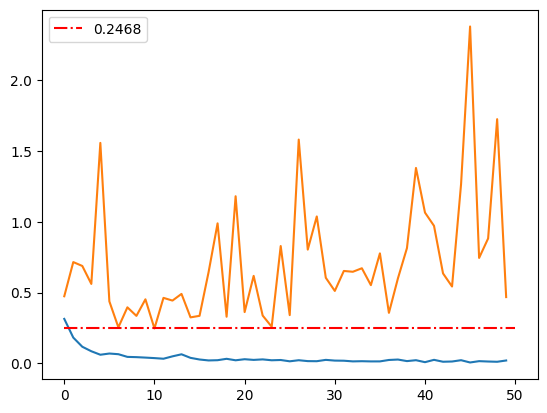

In [41]:
best_model = train_loop(model, device, optimizer, criterion, train_loader, dev_loader, dropout=dropout, epochs=50)

In [42]:
X, y = next(iter(dev_loader))
X.shape, y.shape

(torch.Size([1302, 6, 400]), torch.Size([1302, 1]))

              precision    recall  f1-score   support

           0       0.98      0.91      0.94       651
           1       0.92      0.98      0.95       651

    accuracy                           0.95      1302
   macro avg       0.95      0.95      0.95      1302
weighted avg       0.95      0.95      0.95      1302



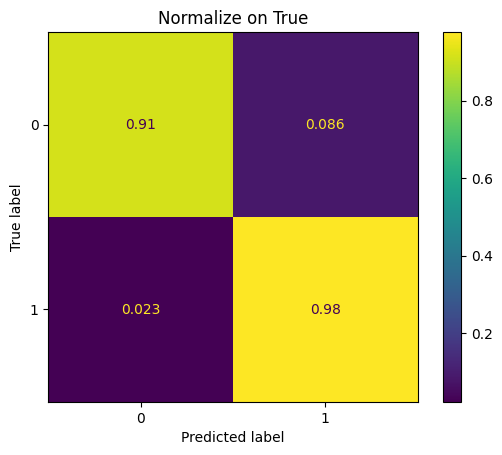

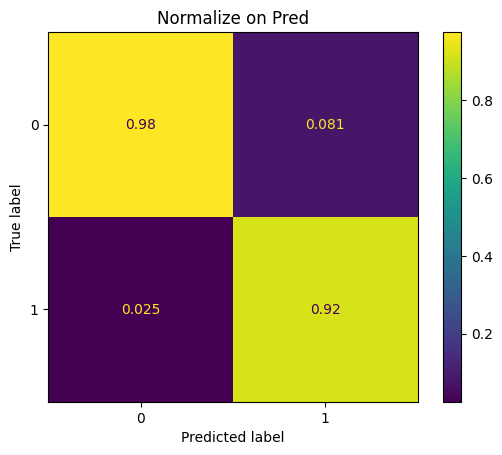

In [43]:
eval_loop(best_model, X, y)

In [ ]:
# torch.save(best_model.state_dict(), '95f1_ACIDENTALSAVE87posweight.pth') 